In [1]:
# Libraries import
import numpy as np 
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import Dense, Flatten, Reshape, UpSampling2D,BatchNormalization, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import plotly.express as px 

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# The goal is to use GAN to improve accuracy of number 7 in Mnist dataset.

We first load the dataset and split it into train and test. The Mnist dataset already has its own train and test batches.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]

In [4]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')

Input data shape: (6200, 28, 28)
Number of labels: 6200


In [5]:
# Data normalization
x_train = x_train / 255
x_test = x_test / 255

# We form tensors for training and test samples
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Splitting the training sample into BATCHES
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

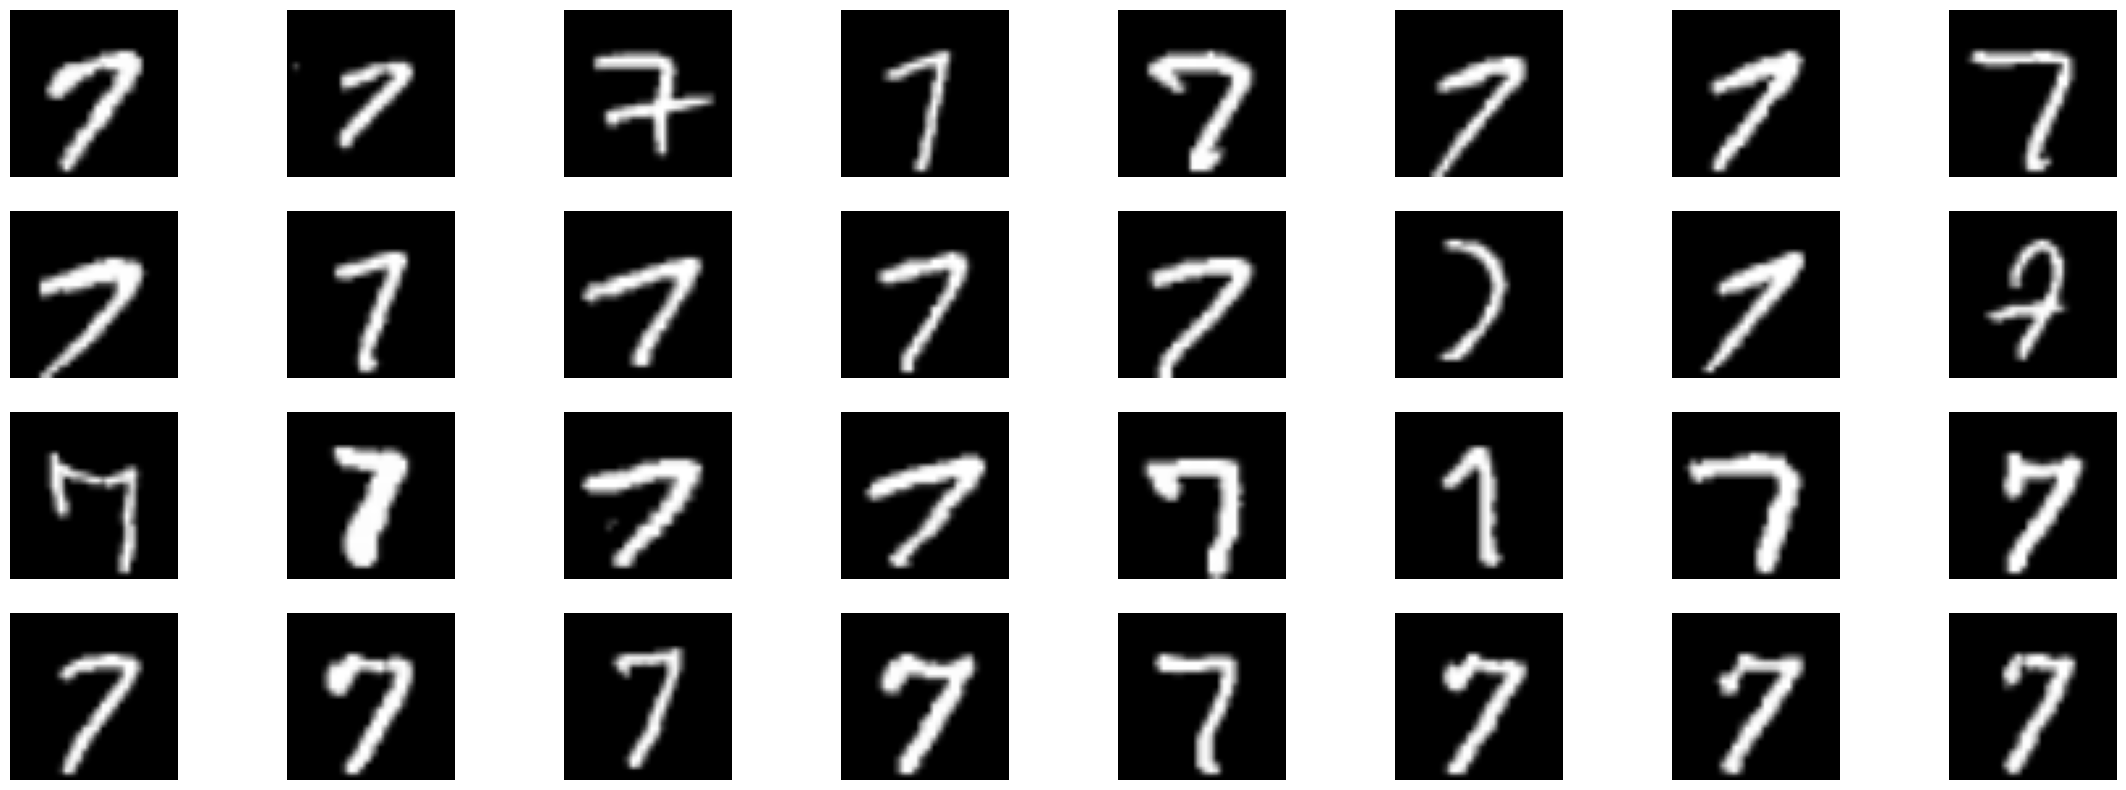

In [6]:
cnt_imgs = 32  
counter = 0 
IMAGE_SIZE = (64, 64)
plt.figure(figsize=(28, 10))
for img in x_train:
    plt.subplot(4, 8, counter + 1)
    draw_img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(draw_img, cmap='gray')
    plt.axis('off')
    counter += 1
    if counter == cnt_imgs:
        break

In [9]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Function of finding the value of the loss function for the generator (for BATCH)"""
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    """Function of finding the value of the loss function for the discriminator (for BATCH)"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss

In [10]:
generator_optimizer = tf.optimizers.Adam(2e-4)
discriminator_optimizer = tf.optimizers.Adam(2e-4)

In [11]:
hidden_dim = 2

In [12]:
generator = Sequential(name='generator')
generator.add(Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim, )))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 256)))  # got a tensor
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))

In [13]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             37632     
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                         

In [14]:
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='elu', input_shape=(28, 28, 1)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='elu'))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid')) 

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dense_2 (Dense)             (None, 1)               

In [16]:
# compiling neural networks
generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [17]:
winning_images = []

@tf.function
def train_step(images) -> (float, float, tf.Tensor):
    """Function for updating weight coefficients at one training step (for one BATCH)"""
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        
        # Identify winning generated images
        winning_indices = tf.where(fake_output > 0.5)
        winning_batch = tf.gather(generated_images, winning_indices)
        
        return gen_loss, disc_loss, winning_batch

def train(dataset, epochs) -> None:
    """A function to start the learning process for all epochs for the generator and discriminator"""
    history = []
    max_print_label = 10
    th = BUFFER_SIZE // (BATCH_SIZE * max_print_label)
    
    for epoch in range(1, epochs + 1):
        print(f'{epoch}/{epochs}: ', end='')
        start = time.time()
        n = 0
        gen_loss_epoch = 0 
        for image_batch in dataset:
            gen_loss, disc_loss, winning_batch = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            
            # Store winning generated images
            winning_images.extend(winning_batch.numpy())
            
            if (n % th == 0):
                print('=', end='')
            n += 1
        print('>', end=' ')
        
        history += [gen_loss_epoch / n]
        print(': loss = ' + str(history[-1]))
        print(f'The time of the epoch {epoch} is: {time.time() - start} second')
        
    return history, winning_images


In [18]:
EPOCHS = 100
gen_history, gan = train(train_dataset, EPOCHS)

1/100: ===========> : loss = tf.Tensor(4.600982, shape=(), dtype=float32)
The time of the epoch 1 is: 18.605354070663452 second
2/100: ===========> : loss = tf.Tensor(5.786489, shape=(), dtype=float32)
The time of the epoch 2 is: 17.122422218322754 second
3/100: ===========> : loss = tf.Tensor(7.0294805, shape=(), dtype=float32)
The time of the epoch 3 is: 17.964588165283203 second
4/100: ===========> : loss = tf.Tensor(7.792152, shape=(), dtype=float32)
The time of the epoch 4 is: 18.202139139175415 second
5/100: ===========> : loss = tf.Tensor(4.2149487, shape=(), dtype=float32)
The time of the epoch 5 is: 18.09325337409973 second
6/100: ===========> : loss = tf.Tensor(2.1555893, shape=(), dtype=float32)
The time of the epoch 6 is: 18.290640354156494 second
7/100: ===========> : loss = tf.Tensor(2.1373398, shape=(), dtype=float32)
The time of the epoch 7 is: 17.513395071029663 second
8/100: ===========> : loss = tf.Tensor(2.6826987, shape=(), dtype=float32)
The time of the epoch 8 is

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


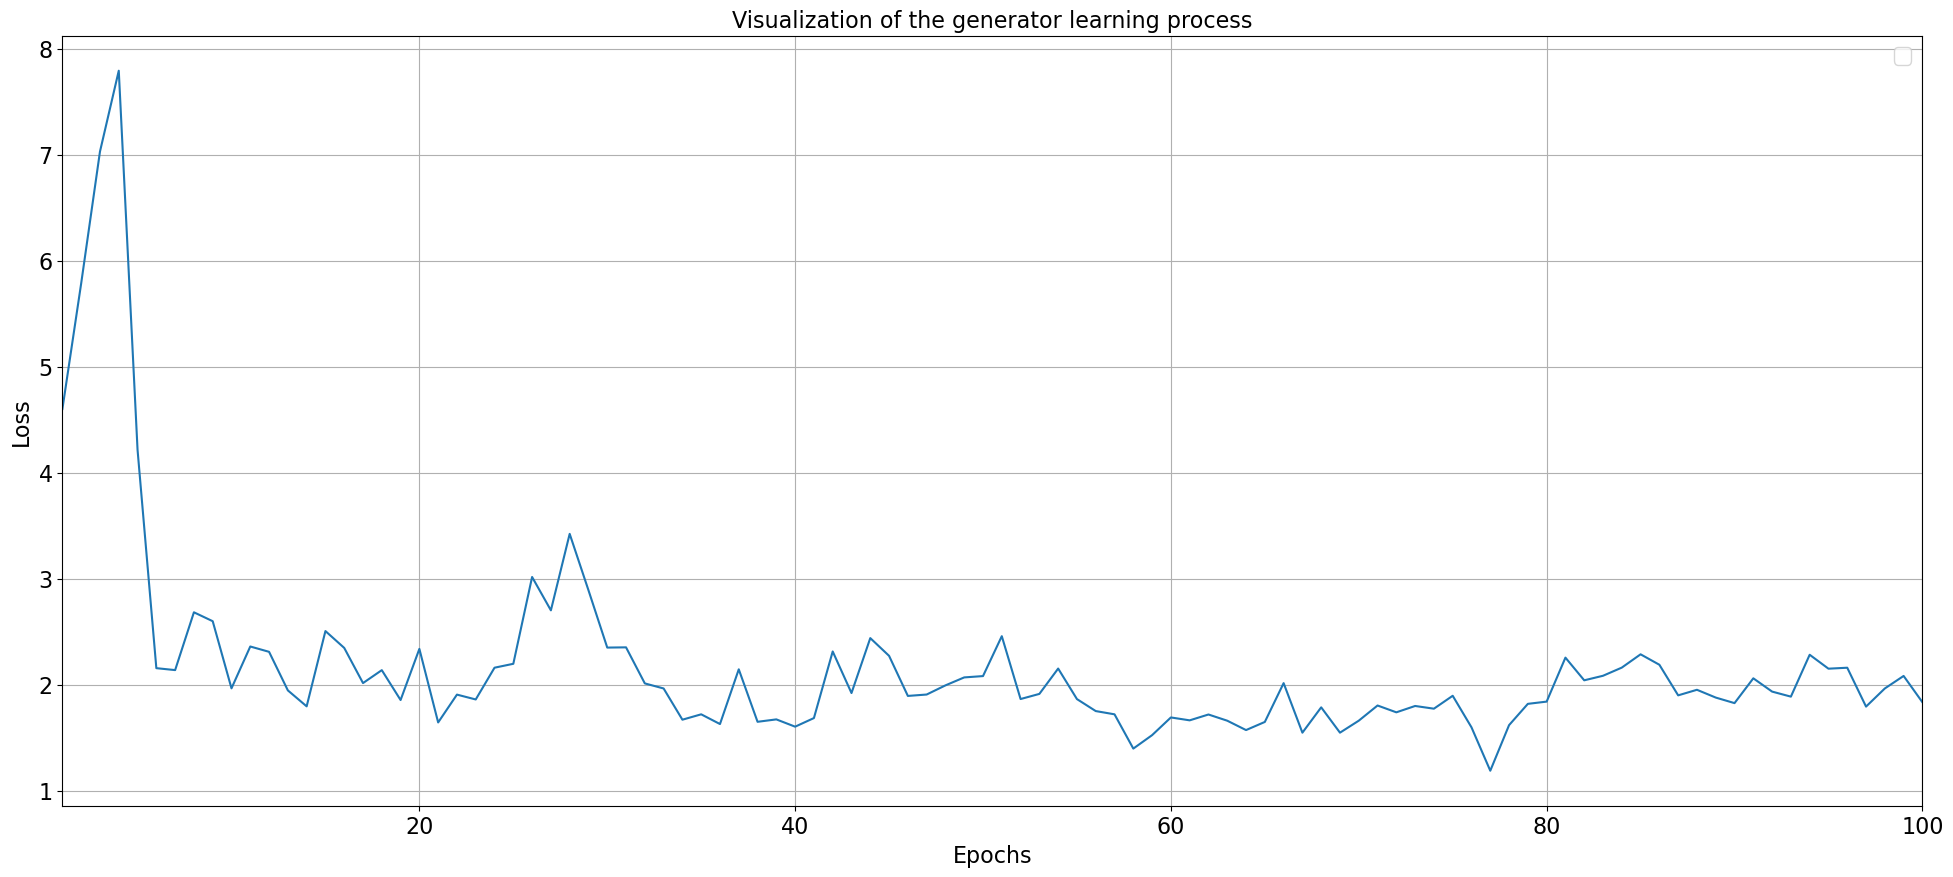

In [19]:
plt.figure(figsize=(24, 10))
plt.title('Visualization of the generator learning process', fontsize=16)
plt.plot(np.arange(1, EPOCHS + 1), gen_history) 
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1, EPOCHS)
plt.grid()
plt.legend(fontsize=16)
plt.show()

1/1 [==============================] - 0s 18ms/step


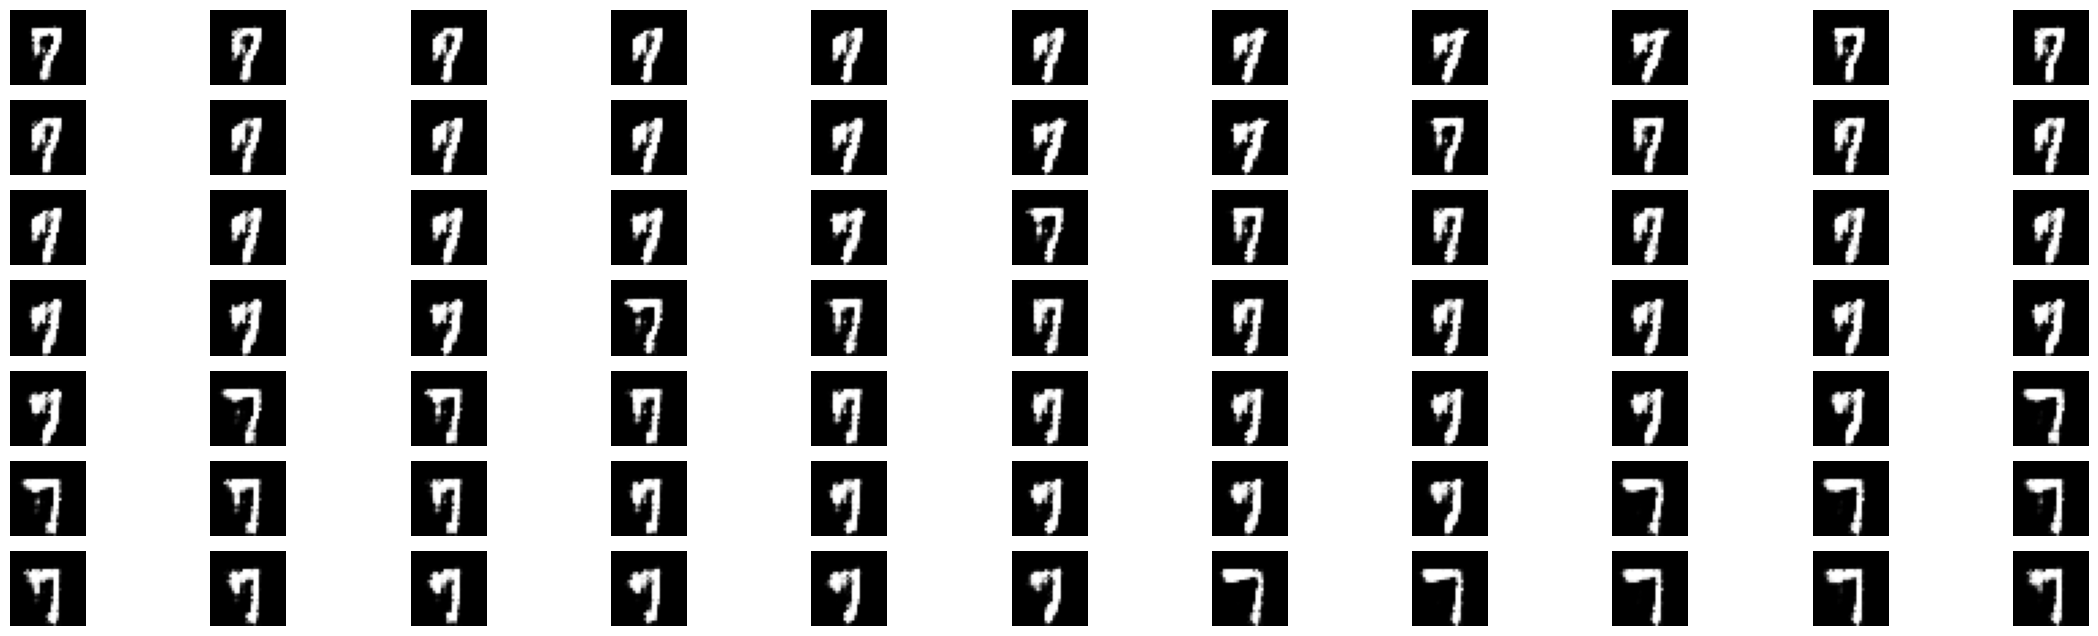

In [20]:
n = 4
total = 2 * n + 1
cnter = 0
plt.figure(figsize=(28, 8))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(7, 11, num)
        num += 1
        img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
        plt.imshow(img[0, :, :, 0], cmap='gray')
        plt.axis('off')
        if num == 78:
            break
plt.show()

In [21]:
gan_np = np.array(gan)

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [23]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(f'Input data shape: {x_train.shape}')
print(f'Number of labels: {y_train.size}')

Input data shape: (60000, 28, 28)
Number of labels: 60000


In [24]:
x_train = x_train / 255
x_test = x_test / 255

# We form tensors for training and test samples
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [25]:
num_samples = 200
sampled_images = gan_np[:num_samples]

In [26]:
# Select one duplicate from the sampled images
sampled_images_selected = sampled_images[:, 0, :, :, 0]

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_mnist_classifier(input_shape=(28, 28, 1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the classifier model
classifier_model = create_mnist_classifier()

# Compile the model
classifier_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Print model summary
classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 576)              

In [28]:
twos_array = np.full(200, 7)
y_train_updated = np.concatenate([y_train, twos_array])

In [30]:
sampled_images_selected = sampled_images_selected.reshape(sampled_images_selected.shape[0], 28, 28, 1)

In [31]:
x_train_updated = np.concatenate([x_train, sampled_images_selected])

In [33]:
# Fit the classifier model
history = classifier_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2, shuffle = True)


x_test = x_test[y_test == 7]
y_test = y_test[y_test == 7]

Epoch 1/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0602 - accuracy: 0.9808 - val_loss: 0.0507 - val_accuracy: 0.9852
Epoch 2/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0394 - accuracy: 0.9875 - val_loss: 0.0448 - val_accuracy: 0.9867
Epoch 3/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0525 - val_accuracy: 0.9859
Epoch 4/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.0628 - val_accuracy: 0.9823
Epoch 5/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0190 - accuracy: 0.9940 - val_loss: 0.0488 - val_accuracy: 0.9869


In [34]:
# Evaluate the model on the test set
test_loss, test_accuracy = classifier_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

33/33 [==============================] - 0s 3ms/step - loss: 0.0765 - accuracy: 0.9776
Test Loss: 0.07651475071907043
Test Accuracy: 0.9776264429092407


In [35]:
del classifier_model

In [38]:
history = classifier_model.fit(x_train_updated, y_train_updated, epochs=5, batch_size=32, validation_split=0.2, shuffle = True)

Epoch 1/5
1505/1505 [==============================] - 23s 15ms/step - loss: 0.1657 - accuracy: 0.9498 - val_loss: 0.0759 - val_accuracy: 0.9760
Epoch 2/5
1505/1505 [==============================] - 25s 16ms/step - loss: 0.0514 - accuracy: 0.9838 - val_loss: 0.0921 - val_accuracy: 0.9706
Epoch 3/5
1505/1505 [==============================] - 18s 12ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0782 - val_accuracy: 0.9721
Epoch 4/5
1505/1505 [==============================] - 17s 11ms/step - loss: 0.0276 - accuracy: 0.9909 - val_loss: 0.0673 - val_accuracy: 0.9765
Epoch 5/5
1505/1505 [==============================] - 17s 11ms/step - loss: 0.0229 - accuracy: 0.9927 - val_loss: 0.0678 - val_accuracy: 0.9792


In [39]:
test_loss, test_accuracy = classifier_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

33/33 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.9932
Test Loss: 0.020955292508006096
Test Accuracy: 0.9931906461715698
